# Imports & Global Setup

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")


# Load All Datasets

In [34]:
BASE_PATH = "../hackathonproject/brazilian-ecommerce/"

customers = pd.read_csv(BASE_PATH + "olist_customers_dataset.csv")
orders = pd.read_csv(
    BASE_PATH + "olist_orders_dataset.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date"
    ]
)
reviews = pd.read_csv(
    BASE_PATH + "olist_order_reviews_dataset.csv",
    parse_dates=["review_creation_date", "review_answer_timestamp"]
)
order_items = pd.read_csv(BASE_PATH + "olist_order_items_dataset.csv")
products = pd.read_csv(BASE_PATH + "olist_products_dataset.csv")
category_translation = pd.read_csv(
    BASE_PATH + "product_category_name_translation.csv"
)

print("Loaded successfully")


Loaded successfully


# Merge Data

### Orders + Customers

In [35]:
df = orders.merge(
    customers,
    on="customer_id",
    how="left"
)


### Orders + Reviews (1 review per order)

In [36]:
df = df.merge(
    reviews[
        ["order_id", "review_score"]
    ],
    on="order_id",
    how="left"
)


### Orders + Order Items (AGGREGATE FIRST)

In [37]:
order_items_agg = (
    order_items
    .groupby("order_id")
    .agg(
        price=("price", "sum"),
        freight_value=("freight_value", "sum"),
        items_count=("order_item_id", "count")
    )
    .reset_index()
)

df = df.merge(
    order_items_agg,
    on="order_id",
    how="left"
)


### Add Product Category (dominant product per order)

In [38]:
order_product = (
    order_items
    .merge(products, on="product_id", how="left")
    .merge(category_translation, on="product_category_name", how="left")
    .groupby("order_id")
    .first()
    .reset_index()
)

df["product_category"] = order_product["product_category_name_english"]


# Keep Only Satisfaction-Relevant Orders

In [39]:
df = df[
    df["order_status"] == "delivered"
].copy()


# Business Feature Engineering

### Customer Satisfaction Flag (MAIN KPI)

In [40]:
df["is_unhappy"] = (df["review_score"] <= 2).astype(int)


### Delivery Delay

In [41]:
df["delivery_delay_days"] = (
    df["order_delivered_customer_date"]
    - df["order_estimated_delivery_date"]
).dt.days


### Delay Buckets

In [42]:
def delay_bucket(x):
    if pd.isna(x):
        return "Unknown"
    elif x <= 0:
        return "On Time"
    elif x <= 3:
        return "Late (1–3 days)"
    else:
        return "Very Late (>3 days)"

df["delay_bucket"] = df["delivery_delay_days"].apply(delay_bucket)


### Cost Perception Metric

In [43]:
df["freight_to_price_ratio"] = df["freight_value"] / df["price"]
df = df[df["freight_to_price_ratio"] <= 3]  # cap outliers
df


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,price,freight_value,items_count,product_category,is_unhappy,delivery_delay_days,delay_bucket,freight_to_price_ratio
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4.0,29.99,8.72,1.0,cool_stuff,0,-8.0,On Time,0.290764
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,4.0,118.70,22.76,1.0,pet_shop,0,-6.0,On Time,0.191744
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,5.0,159.90,19.22,1.0,furniture_decor,0,-18.0,On Time,0.120200
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,5.0,45.00,27.20,1.0,perfumery,0,-13.0,On Time,0.604444
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,5.0,19.90,8.72,1.0,garden_tools,0,-10.0,On Time,0.438191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,5.0,72.00,13.08,1.0,NaN,0,-11.0,On Time,0.181667
99988,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,4.0,174.90,20.10,1.0,NaN,0,-2.0,On Time,0.114923
99989,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,5.0,205.99,65.02,1.0,NaN,0,-6.0,On Time,0.315646
99990,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2.0,359.98,81.18,2.0,NaN,1,-21.0,On Time,0.225513


# Final Analytics Dataset (CLEAN)

In [44]:

analytics_df = df[
    [
        "review_score",
        "is_unhappy",
        "delivery_delay_days",
        "delay_bucket",
        "freight_to_price_ratio",
        "payment_type",
        "payment_installments",
        "product_category",
        "customer_state",
        "price",
        "freight_value"
    ]
].dropna()

analytics_df.shape



KeyError: "['payment_type', 'payment_installments'] not in index"

# ESSENTIAL ANALYSES

### Executive KPIs (DASHBOARD CARDS)

In [27]:
kpis = {
    "Average Review Score": round(analytics_df["review_score"].mean(), 2),
    "Unhappy Customers (%)": round(analytics_df["is_unhappy"].mean() * 100, 2),
    "Late Delivery Rate (%)": round((analytics_df["delivery_delay_days"] > 0).mean() * 100, 2),
    "Avg Freight / Price Ratio": round(analytics_df["freight_to_price_ratio"].mean(), 2)
}

kpis


{'Average Review Score': np.float64(4.16),
 'Unhappy Customers (%)': np.float64(12.82),
 'Late Delivery Rate (%)': np.float64(6.65),
 'Avg Freight / Price Ratio': np.float64(0.31)}

### Review Score Distribution

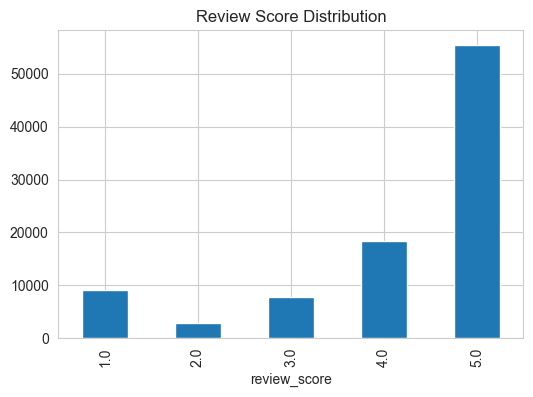

In [28]:
analytics_df["review_score"].value_counts().sort_index().plot(
    kind="bar",
    title="Review Score Distribution",
    figsize=(6,4)
)
plt.show()


### Delivery Delay vs Satisfaction

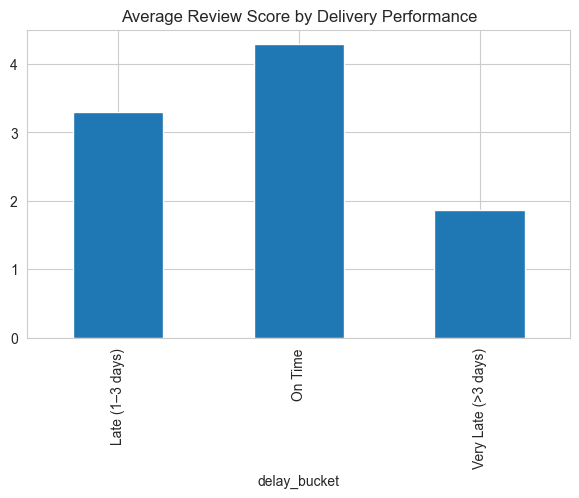

delay_bucket
Late (1–3 days)        32.002219
On Time                 9.292668
Very Late (>3 days)    74.666968
Name: is_unhappy, dtype: float64

In [30]:
delay_vs_review = analytics_df.groupby("delay_bucket")["review_score"].mean()
delay_vs_review.plot(
    kind="bar",
    title="Average Review Score by Delivery Performance",
    figsize=(7,4)
)
plt.show()
analytics_df.groupby("delay_bucket")["is_unhappy"].mean() * 100


### Freight Cost Impact

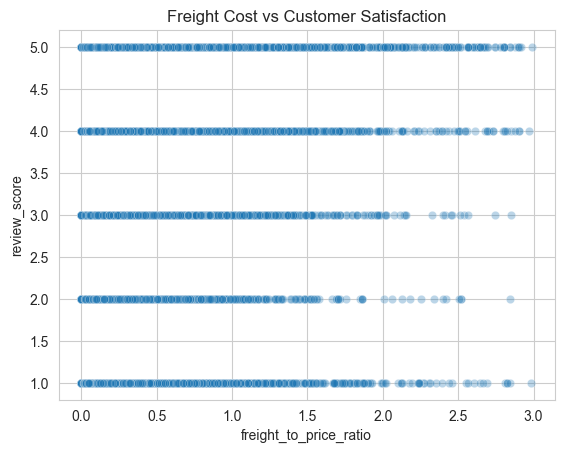

In [31]:
sns.scatterplot(
    data=analytics_df,
    x="freight_to_price_ratio",
    y="review_score",
    alpha=0.3
)
plt.title("Freight Cost vs Customer Satisfaction")
plt.show()


### Payment Experience Impact

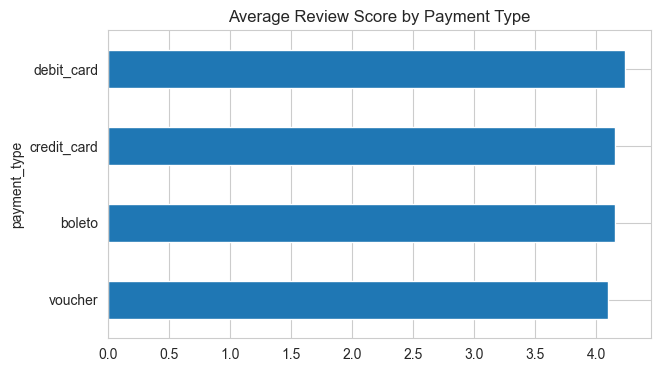

In [32]:
analytics_df.groupby("payment_type")["review_score"].mean().sort_values().plot(
    kind="barh",
    title="Average Review Score by Payment Type",
    figsize=(7,4)
)
plt.show()


### Product Category Satisfaction

In [33]:
category_stats = (
    analytics_df
    .groupby("product_category")
    .agg(
        avg_review=("review_score", "mean"),
        unhappy_rate=("is_unhappy", "mean"),
        orders=("review_score", "count")
    )
    .query("orders > 200")
    .sort_values("unhappy_rate", ascending=False)
)

category_stats.head(10)


,avg_review,unhappy_rate,orders
product_category,,,
furniture_living_room,4.034739,0.153846,403
construction_tools_construction,4.115599,0.149025,718
drinks,4.078571,0.146429,280
audio,4.101493,0.140299,335
fixed_telephony,4.140097,0.140097,207
luggage_accessories,4.133810,0.138917,979
garden_tools,4.128228,0.138320,3369
small_appliances,4.092715,0.137417,604
home_appliances_2,4.172566,0.137168,226


### Geographic Satisfaction

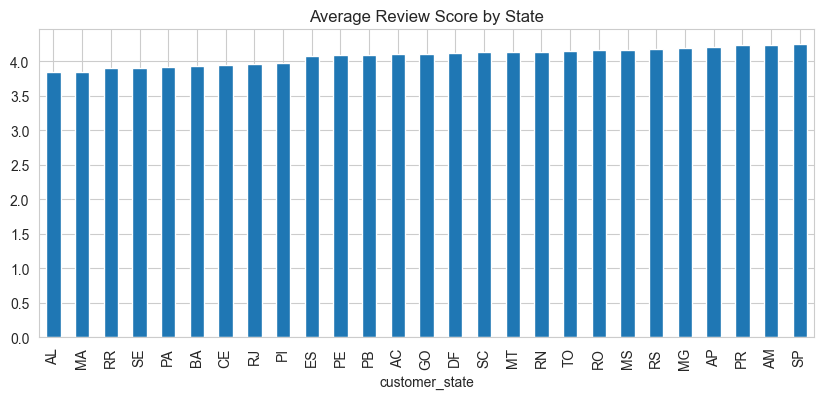

In [34]:
analytics_df.groupby("customer_state")["review_score"].mean().sort_values().plot(
    kind="bar",
    title="Average Review Score by State",
    figsize=(10,4)
)
plt.show()


In [35]:
analytics_df.to_csv("analytics_data.csv", index=False)


In [46]:
df.to_csv("final_merged_data.csv", index=False)